In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)

In [24]:
books = pd.read_csv("../data/books.csv")

In [25]:
# books.head()
books.columns

Index(['isbn13', 'isbn10', 'title', 'subtitle', 'authors', 'categories',
       'thumbnail', 'description', 'published_year', 'average_rating',
       'num_pages', 'ratings_count'],
      dtype='object')

In [26]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   description     6548 non-null   object 
 8   published_year  6804 non-null   float64
 9   average_rating  6767 non-null   float64
 10  num_pages       6767 non-null   float64
 11  ratings_count   6767 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 638.6+ KB


#### Observations
- The isbn numbers and title are unique for all the books, however the title could be useful when recommending the second part. ISBN numbers can be deleted
- subtitle has a lot of null values (6810 - 2381)
- Categories have many different categories, doesn't make sense, could be hyper specific, needs standardization.
- The most important column, description, has a few missing columns.

#### Find Patterns in Missing values

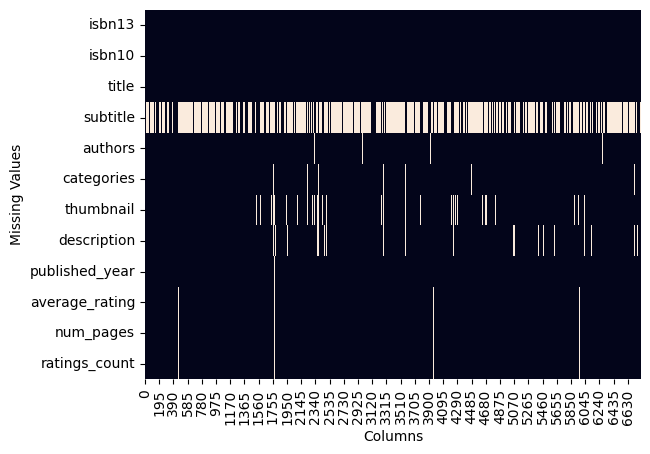

In [27]:
ax = plt.axes()
sns.heatmap(books.isna().transpose(), ax=ax, cbar=False)

plt.xlabel("Columns")
plt.ylabel("Missing Values")
plt.show()

### Observations
- As we've seen, many subtitles are missing
- Another interesting thing we see here is that the missing values for average_rating, num_pages and ratings count are all correlated. This could mean that they were taken from the same dataset where this information was not available. This could mean introducing some bias into the model if it means that these books are newer etc.
- categories, thumbnail and description are mostly missing at random.

Since 'description' is still largely our most important column, it is worth further investigating into the patterns of missingness within that column.


In [28]:
books["missing_description"] = np.where(books.description.isna(), 1, 0)
books["age_of_book"] = 2025 - books["published_year"]

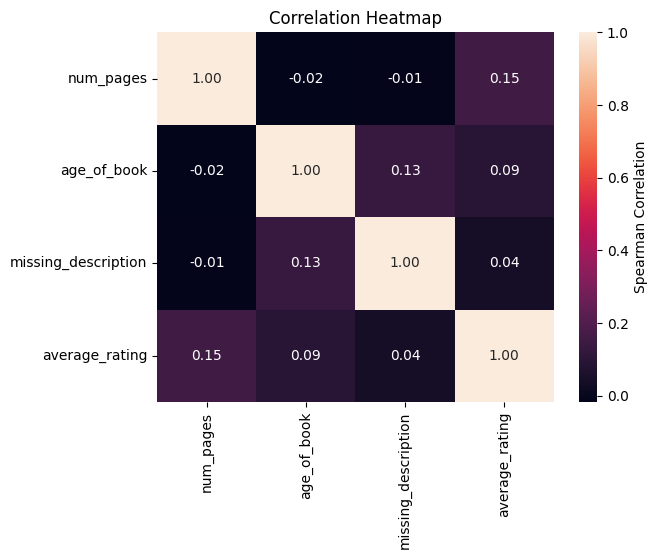

In [29]:
columns_of_interest = books[["num_pages", "age_of_book", "missing_description", "average_rating"]]

# Spearman is more appropriate when dealing with non-continuous variables (like missing description[binary])
corr_matrix = columns_of_interest.corr(method="spearman")

heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cbar_kws={"label": "Spearman Correlation"})
heatmap.set_title("Correlation Heatmap")
plt.show()

We're trying to see if the missing description has any correlation features of the books. This is important in case we want to drop the books with missing descriptions. We check this to make sure that if we do, we're not going to be creating a bias within the model for certain kinds of books.

#### Observations
- The columns don't seem to have a strong correlation with our missing descriptions.

#### Action
- Since going out of our way to restore these descriptions would be a pain as we'd have to potentially use webscraping.
- And since there doesn't seem to be a pattern in the missing descriptions, we might as well drop the books without a description.


In [30]:
missing = books[books.description.isna() | 
      books.num_pages.isna() | 
      books.average_rating.isna() | 
      books.published_year.isna()
]

missing.shape

(303, 14)

We are missing 303 books, if we just blindly filter them out. Since this is well below the 5% mark (our dataset has 6810 books). It is okay to do this for now.

In [31]:
books_missing = books.dropna(subset=['description', 'num_pages', 'average_rating', 'published_year'])
books_missing.shape

(6507, 14)

Going back to category

In [32]:
categories_count = books_missing.categories.value_counts().reset_index()
categories_count

,categories,count
0,Fiction,2523
1,Juvenile Fiction,534
2,Biography & Autobiography,391
3,History,258
4,Literary Criticism,164
...,...,...
526,Actresses,1
527,Apartments,1
528,Books,1
529,Antislavery movements,1


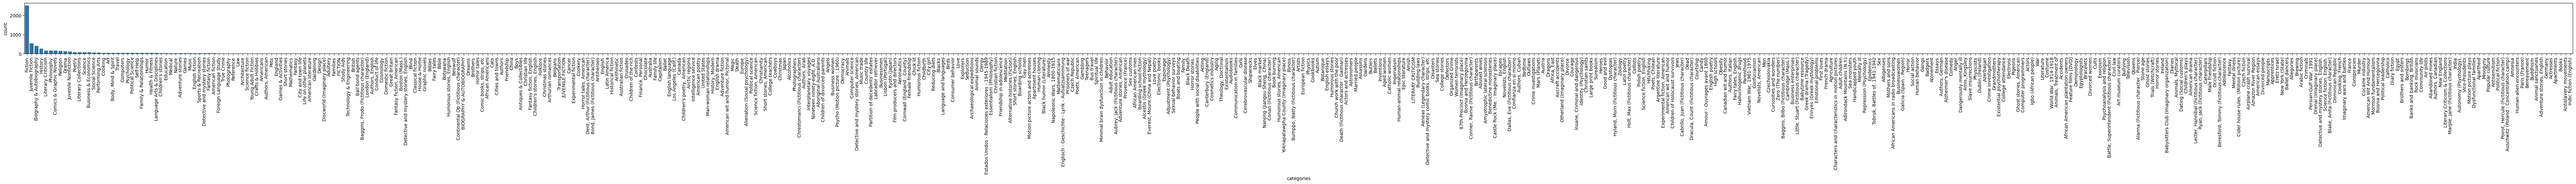

In [33]:
# Visualizing
fig, ax = plt.subplots(figsize=(100,2))
sns.barplot(categories_count, x='categories', y='count', ax=ax)
ax.tick_params(axis='x', rotation=90)
plt.show()

#### Observations
- If you zoom in into the plot, you'll see that most categories are really specific and have just 1 value in them. This would be a nightmare for one hot encoding. We really need to clean and bin these before moving on.
- Its only the first 2-3 categories that have solid counts, before becoming useless.

Going back to the descriptions columns, we really need to make sure that the information present in there really is meaningful in order to be able to recommend it using the LLM

A good way to check this would be to check the number of words in each description. 

In [34]:
books_missing['words_in_description'] = books_missing.description.str.split().str.len()

/var/folders/cl/553dpnld4gl4779g4kyg3c340000gn/T/ipykernel_44730/2449602824.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_missing['words_in_description'] = books_missing.description.str.split().str.len()


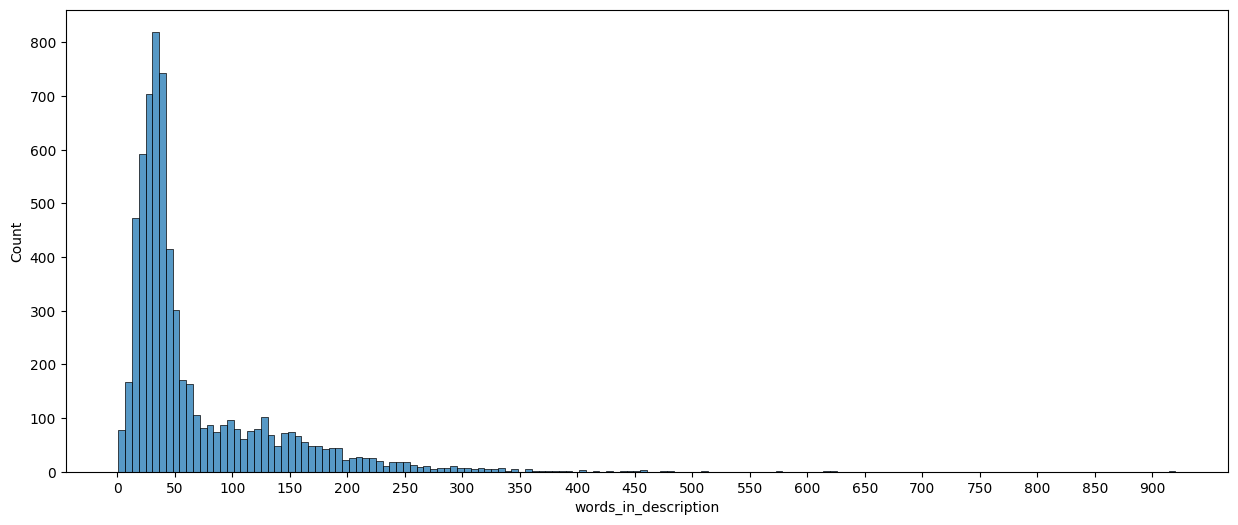

In [35]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(books_missing.words_in_description, ax=ax)
ax.set_xticks(range(0, books_missing.words_in_description.max(), 50));

#### Observations
- Most descriptions have a good amount of words
- We'd probably need to come up with some arbitrarty cutoff
- there's also a few outliers that have descriptions over 400 words.

In [36]:
# taking a look at short descriptions
books_missing.loc[books_missing['words_in_description'].between(1, 4), "description"].reset_index()

,index,description
0,6,Donation.
1,11,Fantasy-roman.
2,748,Includes bibliographical references.
3,770,Bound For Oregon (PB)
4,775,No Marketing Blurb
5,812,No Marketing Blurb
6,857,First published in 1813.
7,944,Edited by Maurice Hindle.
8,953,DEFOE/ROBINSON CRUSOE (BC)
9,954,Edited by John Carey.


These don't seem to be very helpful

In [37]:
# taking a look at short descriptions
books_missing.loc[books_missing['words_in_description'].between(5, 14), "description"].reset_index()

,index,description
0,2,Volume Two of Stephen Donaldson's acclaimed second trilogy featuing the compelling anti-hero Thomas Covenant.
1,38,Koko is Peter Straub's foray into the psychological horror of the Vietnam War.
2,70,A matter of life and death - and the Throne of England
3,77,Nonsense rhyming story. 4 yrs+
4,84,A study guide for the novel There's a Boy in the Girl's bathroom.
...,...,...
303,6715,The first comprehensive guide to addressing Native American issues in teaching children.
304,6726,Presents two complete novels from Henry James.
305,6757,Audio Book- unabriged on CD
306,6776,"Raymond Chandler meets The Exorcist. Classic novel in a signed, limited edition."


These also don't seem very useful

In [38]:
# taking a look at longer descriptions
books_missing.loc[books_missing['words_in_description'].between(15, 24), "description"].reset_index()

,index,description
0,10,"One of Sidney Sheldon's most popular and bestselling titles, repackaged and reissued for a new generation of fans."
1,32,"Tells the story of three generations of Chinese women, beginning at the turn of the century."
2,36,A magical and fantastic collection of early stories by one of the most original children's authors of the 20th century. For 8-11 year olds.
3,57,A young drifter finds more than he bargained for when he agrees to deliver a parcel to an English country house...
4,68,A new 'The Doors of Perception' for the 21st century? A visionary journey from cynicism to shamanism by a brilliant young US writer.
...,...,...
942,6767,Everything from the fingerprints of the gods through the hidden history of the human race.
943,6782,"Displays one of America's leading physicist's fascinating development of personal artistic sensitivity to line, form, and the moods of his subject."
944,6783,"Basics Illustration 01: Thinking Visually explores the importance of ideas, research, drawing and experimentation for the illustrator."
945,6789,"Provides an introduction to the American artist's work, presenting examples of his works with a discussion of their historical background and critical interpretation."


Ehhhhhhh....some are useful, some really are not (like the first one)

In [39]:
# taking a look at longer descriptions
books_missing.loc[books_missing['words_in_description'].between(25, 34), "description"].reset_index()

,index,description
0,9,Kate Blackwell is an enigma and one of the most powerful women in the world. But at her ninetieth birthday celebrations there are ghosts of absent friends and absent enemies.
1,14,"Available in the U.S. for the first time, this is the second volume in the exceptional Legends of the Riftwar series from ""New York Times""-bestselling authors Feist and Rosenberg."
2,20,"It is 1937, and Charles Ashworth, a Canon to the Archbishop of Canterbury, is sent to untangle a web of self-delusion and corruption at the episcopal palace of the charismatic Bishop of Starbridge."
3,21,"Reissue of the author's most famous and well-loved work, the Starbridge series, six self-contained yet interconnected novels that explore the history of the Church of England through the 20th century."
4,46,"No one believes a little girl when she insists that she has witnessed a murder until she herself turns up drowned, and Hercule Poirot sets out to catch the killer."
...,...,...
1224,6760,"Joel, an English teacher, has never really liked Korea, but he decides to extend his stay so that he can pursue Hana, the new receptionist at his school."
1225,6766,"Discusses the historical and intellectual background of the novel ""The Rule of Four,"" examining the 1499 Renaissance text that forms the central theme of the novel."
1226,6775,"Presents nearly one thousand recipes--from appetizers and salads to entrees and desserts--developed by America's Test Kitchen chefs, along with tips for choosing equipment, preparing food, or saving money in the kitchen."
1227,6779,"Edited by the creator and executive producer of the teen detective show, a collection of essays address such varied subjects as Veronica's vigilante justice and Veronica and Loganâ€™s everchanging relationship."


This seems useful now, we really need this to be our cutoff.

In [40]:
books_missing_25_words = books_missing[books_missing['words_in_description'] > 25]

In [41]:
books_missing_25_words.shape

(5088, 15)

We lost a whole bunch of books, but It wouldn't have served as part of our use case anyway. In a different project perhaps we could infer based on the title/subtitle.

Next we see what we can do with the subtitle. In Books its actually quite common to have Title:subtitle as part of the title, so one thing we can consider is joining those two columns.

In [42]:
# np.where(condition, true, false)

books_missing_25_words["title_and_subtitle"] = (
    np.where(books_missing_25_words['subtitle'].isna(), books_missing_25_words.title, 
             books_missing_25_words[['title', 'subtitle']].astype(str).agg(": ".join, axis=1))
)

/var/folders/cl/553dpnld4gl4779g4kyg3c340000gn/T/ipykernel_44730/1395390890.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_missing_25_words["title_and_subtitle"] = (


In [43]:
books_missing_25_words.title_and_subtitle

0                                                                                            Gilead
1                                                                             Spider's Web: A Novel
3                                                                                    Rage of angels
4                                                                                    The Four Loves
5                                                                               The Problem of Pain
                                                   ...                                             
6802                                                                              Mistaken Identity
6803                                                                            Journey to the East
6804    The Monk Who Sold His Ferrari: A Fable About Fulfilling Your Dreams & Reaching Your Destiny
6805                                                 I Am that: Talks with Sri Nisargadatta Maharaj


In [44]:
books_missing_25_words['tagged_description'] = books_missing_25_words[['isbn13', 'description']].astype(str).agg(" ".join, axis=1)

/var/folders/cl/553dpnld4gl4779g4kyg3c340000gn/T/ipykernel_44730/4108785944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_missing_25_words['tagged_description'] = books_missing_25_words[['isbn13', 'description']].astype(str).agg(" ".join, axis=1)


In [45]:
books_missing_25_words.columns

Index(['isbn13', 'isbn10', 'title', 'subtitle', 'authors', 'categories',
       'thumbnail', 'description', 'published_year', 'average_rating',
       'num_pages', 'ratings_count', 'missing_description', 'age_of_book',
       'words_in_description', 'title_and_subtitle', 'tagged_description'],
      dtype='object')

In [46]:
cleaned_books = books_missing_25_words.drop(columns=['isbn10', 'title', 'subtitle', 'missing_description', 
                                     'age_of_book', 'words_in_description', 'thumbnail']);

In [47]:
cleaned_books.to_csv("../data/books_cleaned.csv")